In [9]:
# =========================================================
# 1. Install Library
# =========================================================
!pip -q install pandas matplotlib seaborn scikit-learn langchain_community replicate kaggle tabulate --quiet

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from langchain_community.llms import Replicate
from google.colab import userdata
from tabulate import tabulate

In [ ]:
# =========================================================
# 2. Setup IBM Granite via Replicate
# =========================================================
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token

model = "ibm-granite/granite-3.2-8b-instruct"
output = Replicate(
    model=model,
    replicate_api_token=api_token,
)


In [7]:
# =========================================================
# 3. Download Dataset dari Kaggle (contoh: US Accidents)
# =========================================================
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d sobhanmoosavi/us-accidents
!unzip -q us-accidents.zip

Dataset URL: https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents
License(s): CC-BY-NC-SA-4.0
us-accidents.zip: Skipping, found more recently modified local copy (use --force to force download)
replace US_Accidents_March23.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [29]:
# =========================================================
# 4. Load & Preprocessing Dataset
# =========================================================
df = pd.read_csv("US_Accidents_March23.csv")

cols = ["Severity", "Start_Time", "Weather_Condition", "Visibility(mi)",
        "Precipitation(in)", "Description"]
df = df[cols].dropna()

df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['Hour'] = df['Start_Time'].dt.hour

df['Risk_Level'] = df['Severity'].map({1:"Low", 2:"Medium", 3:"High", 4:"High"})


/tmp/ipython-input-2136237615.py:4: DtypeWarning: Columns (29,30,31,32,33,34,35,36,37,38,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("US_Accidents_March23.csv")


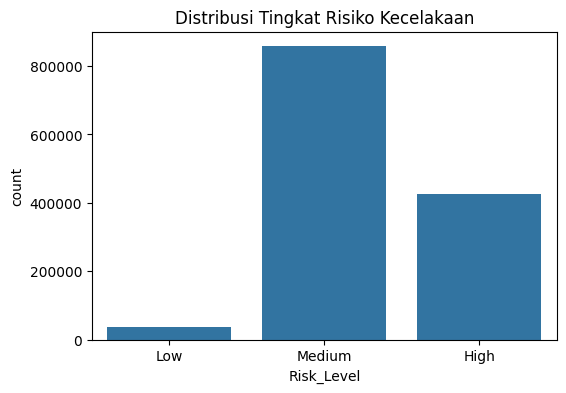

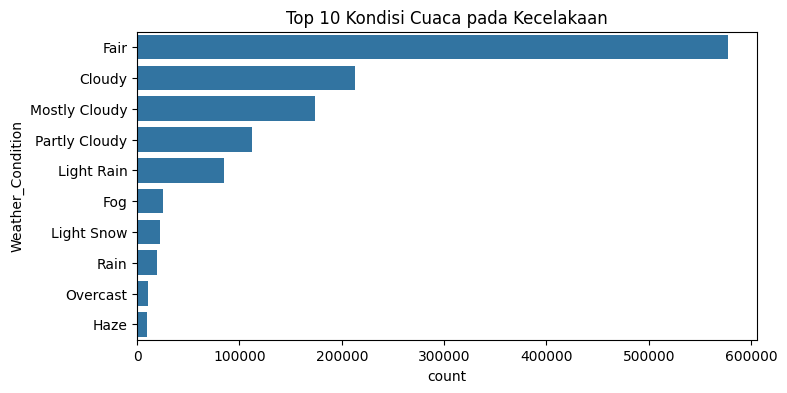

In [30]:
# =========================================================
# 5. EDA (Exploratory Data Analysis)
# =========================================================
plt.figure(figsize=(6,4))
sns.countplot(x="Risk_Level", data=df, order=["Low","Medium","High"])
plt.title("Distribusi Tingkat Risiko Kecelakaan")
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(y="Weather_Condition", data=df, order=df["Weather_Condition"].value_counts().head(10).index)
plt.title("Top 10 Kondisi Cuaca pada Kecelakaan")
plt.show()



In [24]:
# =========================================================
# 6. Modelling ML
# =========================================================
X = df[["Visibility(mi)", "Precipitation(in)", "Hour"]]
y = df["Risk_Level"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# 6.1 Model Awal (Overfitting Check)
model_awal = RandomForestClassifier(random_state=42)
model_awal.fit(X_train, y_train)

train_score_awal = model_awal.score(X_train, y_train)
test_score_awal = model_awal.score(X_test, y_test)
train_acc_awal = accuracy_score(y_train, model_awal.predict(X_train))
test_acc_awal = accuracy_score(y_test, model_awal.predict(X_test))

print("=== Model Awal (Tanpa Penyesuaian) ===")
print(f"Train Score   : {train_score_awal:.4f}")
print(f"Test Score    : {test_score_awal:.4f}")
print(f"Train Accuracy: {train_acc_awal:.4f}")
print(f"Test Accuracy : {test_acc_awal:.4f}\n")


=== Model Awal (Tanpa Penyesuaian) ===
Train Score   : 0.6610
Test Score    : 0.6535
Train Accuracy: 0.6610
Test Accuracy : 0.6535



In [26]:
# 6.2 Model Setelah Penyesuaian
model_tuned = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4,
    random_state=42
)
model_tuned.fit(X_train, y_train)

train_score_tuned = model_tuned.score(X_train, y_train)
test_score_tuned = model_tuned.score(X_test, y_test)
train_acc_tuned = accuracy_score(y_train, model_tuned.predict(X_train))
test_acc_tuned = accuracy_score(y_test, model_tuned.predict(X_test))

print("=== Model Setelah Penyesuaian ===")
print(f"Train Score   : {train_score_tuned:.4f}")
print(f"Test Score    : {test_score_tuned:.4f}")
print(f"Train Accuracy: {train_acc_tuned:.4f}")
print(f"Test Accuracy : {test_acc_tuned:.4f}\n")


=== Model Setelah Penyesuaian ===
Train Score   : 0.6561
Test Score    : 0.6544
Train Accuracy: 0.6561
Test Accuracy : 0.6544



In [14]:
# =========================================================
# 7. IBM Granite: Analisis Laporan Kecelakaan
# =========================================================
sample_descriptions = df["Description"].sample(3, random_state=42).tolist()
descriptions_text = "\n".join([f"Incident {i+1}: {desc}" for i, desc in enumerate(sample_descriptions)])

prompt = f"""
You are an AI traffic safety expert.Analyze these traffic incident descriptions, summarize the main causes, classify them into categories (e.g., Weather-related, Human Error, Road Condition), and provide safety recommendations.

{descriptions_text}
"""

granite_response = output.invoke(prompt)
print("=== IBM Granite Analysis ===\n")
print(granite_response)

=== IBM Granite Analysis ===

**Incident Analysis:**

1. **Incident 1:** 
   - **Summary of Main Causes:** The description does not provide explicit causes, but common factors could include human error (distracted driving, speeding), road conditions (poor visibility, construction zones), or weather-related issues (rain, fog).
   - **Classification:** Human Error (most likely), Road Condition, or Weather-related.
   - **Safety Recommendations:** 
     - Encourage drivers to pay full attention to the road and avoid distractions.
     - Advise drivers to adhere to speed limits and adjust driving according to weather conditions.
     - Regularly inspect and maintain road infrastructure to ensure safety.

2. **Incident 2:**
   - **Summary of Main Causes:** Similar to Incident 1, causes could be human error (reckless driving, lane changing without checking blind spots), or road conditions (debris, potholes).
   - **Classification:** Human Error, Road Condition.
   - **Safety Recommendations:

In [15]:
# =========================================================
# 8. IBM Granite: Insight & Rekomendasi dalam Tabel
# =========================================================
parameters = {
    "top_k": 3,
    "top_p": 1.0,
    "max_tokens": 256,
    "min_tokens": 0,
    "random_seed": None,
    "repetition_penalty": 1.0,
    "stopping_criteria": "length (256 tokens)",
    "stopping_sequence": None
}

refined_prompt = f"""
For the following traffic incidents, provide a table with columns:
Incident No, Risk Level (Low/Medium/High), Main Cause, and 2 Safety Recommendations.

{descriptions_text}
"""

granite_table_response = output.invoke(refined_prompt, parameters=parameters)

print("\n=== IBM Granite Table Output ===\n")
print(granite_table_response)



=== IBM Granite Table Output ===

| Incident No | Risk Level | Main Cause | Safety Recommendations |
|-------------|------------|------------|-----------------------|
| 1           | High       | Reckless Driving, Speeding, or Distracted Driving | 1. Implement stricter speed enforcement and consider lowering speed limits in high-risk areas. 2. Launch public awareness campaigns to discourage distracted driving and promote safe driving habits. |
| 2           | Medium     | Incorrect Lane Usage, Aggressive Driving | 1. Clearly mark HOV lanes and strictly enforce rules to prevent unauthorized vehicle entry. 2. Encourage driver education programs focusing on lane discipline and courteous driving. |
| 3           | Medium     | Tailgating, Speeding, or Inattention | 1. Install adaptive traffic signal controls to improve traffic flow and reduce tailgating. 2. Conduct targeted enforcement campaigns to deter speeding and inattentive driving. |


In [16]:
# =========================================================
# 10. Rekomendasi Umum untuk Pengendara
# =========================================================
recommendation_prompt = f"""
You are an AI traffic safety advisor.Based on traffic accident patterns in the dataset (including weather, visibility, and time of day), generate 10 practical and specific safety recommendations for drivers to reduce accident risk. Each recommendation should be clear, concise, and actionable.
"""

recommendations = output.invoke(recommendation_prompt)

print("\n=== Rekomendasi Keselamatan untuk Pengendara ===\n")
print(recommendations)

# Simpan rekomendasi ke file
with open("driver_safety_recommendations.txt", "w") as f:
    f.write(recommendations)

print("\nSafety recommendations saved to driver_safety_recommendations.txt")



=== Rekomendasi Keselamatan untuk Pengendara ===

1. **Adjust Driving to Weather Conditions:** Always adjust your driving style according to the weather. In rain, snow, or fog, reduce your speed, increase following distance, and use low-beam headlights to improve visibility.

2. **Improve Visibility at Night:** Ensure your vehicle's headlights and taillights are clean and functioning properly. Use high-beam headlights when there's no oncoming traffic to maximize visibility.

3. **Avoid Driving During Peak Rush Hours:** If possible, avoid driving during peak rush hours when traffic congestion is high. This can reduce the likelihood of accidents caused by stress and fatigue.

4. **Stay Alert at Dawn and Dusk:** These periods have reduced visibility due to the position of the sun. Be extra cautious, increase your following distance, and avoid distractions.

5. **Avoid Driving Under the Influence:** Never drive under the influence of alcohol or drugs. This significantly impairs judgment, 